# Communication network

Загрузка и считывание графа

Анализируемые данные содержат сообщения из канала `_jobs` в slack cобществе ODS за период с 2015-04-14 по 2021-07-19

**Описание сети:** узлы сети - пользователи, ребра - реакция пользователя на пост с вакансией. Граф направленный: направление от того, кто поставил реакцию, к автору поста. Однако не всегда можно проанализировать направленный граф (например, направленный граф исследуемой сети не является связным - пользователь опубликовал вакансию, но не поставил никому реакцию), поэтому будем исследовать также и ненаправленный граф.
У узлов графа есть атрибут: компания, в которой пользователь работает (от лица которой публикует вакансию). Атрибуты ребер - положительная, отрицательная или нейтральная реакция на пост с вакансией. Пользователь может поставить к одному посту реакции с разным оттенком, поэтому в качестве атрибута связи будем учитывать средний оттенок реакций одного пользователя к посту

<!---Предположения по сети:
- в графе четко выделены hubs & authorities
- пользователи из одной компании ставят друг другу больше положительных реакций или ставят реакции только своим коллегам
- пользователи из одной компании более тесно связаны в графе (возможно наблюдаются кластеры)-->

Работы по анализу вакансий Слака:
* https://github.com/kuk/analyze-ods-jobs
* https://github.com/egorborisov/jobs_article и статья на habr https://habr.com/ru/company/ods/blog/572264/
* https://github.com/AndreyKolomiets/ods_jobs_analytics

Данные и скрипт по загрузке данных взяты из https://github.com/egorborisov/jobs_article

In [1]:
import glob
import itertools
import os
import re
from collections import defaultdict
from datetime import datetime
from json import load

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

sns.set_theme()

In [2]:
def read_json(filename):
    with open(filename, encoding="utf-8") as file:
        return load(file)


def convert_ts(ts):
    if isinstance(ts, float) and ts == ts and ts is not None:
        return datetime.fromtimestamp(ts)
    else:
        return None


def load_messages(channel):
    """Загружаем все сообщения в pandas DataFrame и убираем технические записи"""
    # Загрузка данных
    data = []
    links = glob.glob(os.path.join(channel, "*.json"))
    for link in links:
        file = read_json(link)
        data = data + file
    data = pd.DataFrame(data)
    print(f"Загружено {len(data)} cообщений")

    # Убираем технические сообщения
    select = (data.upload.isna()) & (data.display_as_bot.isna()) & data.subtype.isna()
    data = data[select]
    print(f"\tУдалены технические сообщения: {sum(~select) } сообщений")

    # Оставляем только выбранные колонки
    cols = [
        "ts",
        "user",
        "text",
        "user_profile",
        "attachments",
        "edited",
        "reactions",
        "thread_ts",
        "reply_count",
        "reply_users_count",
        "latest_reply",
        "reply_users",
        "replies",
        "subscribed",
        "parent_user_id",
        "last_read",
        "client_msg_id",
        "blocks",
    ]

    # Меняем формат для дат
    data["ts"] = ((data["ts"].astype("float")).apply(convert_ts)).dt.round("s")
    data["thread_ts"] = ((data["thread_ts"].astype("float")).apply(convert_ts)).dt.round("s")
    print(f"\tДата и время округлены до секунд и переведены в datetime формат")

    # Очищаем и предобрабатываем текст
    data["text"] = data["text"].str.lower().str.strip()
    data["text"] = data.text.str.replace("\xa0", " ")
    print(f"\tТекст приведен к маленьким буквам и очищен от лишних пробелов")

    print(f"Осталось {len(data)} cообщений")

    return data.loc[:, cols].reset_index(drop=True)

In [3]:
x = load_messages("data")

Загружено 49912 cообщений
	Удалены технические сообщения: 6898 сообщений
	Дата и время округлены до секунд и переведены в datetime формат
	Текст приведен к маленьким буквам и очищен от лишних пробелов
Осталось 43014 cообщений


Алгоритм отбора записей в граф:

- применим фильтр, что сообщение основное (не из треда)
- возьмем сообщения с вакансиями только за 2021 год
- для каждого пользователя будем учитывать только одну последнюю вакансию
- поскольку реакций к постам может быть очень много, в графе учитываются реакции только тех, кто постил хотя бы одну вакансию за период с 2020-06-01. Таким образом, у каждого пользователя в сети должна быть компания

In [4]:
# общее кол-во вакансий за период
x[x["ts"] == x["thread_ts"]].shape[0]

2607

In [5]:
# период с выгрузкой вакансий
x["ts"].min(), x["ts"].max()

(Timestamp('2015-04-14 11:20:20'), Timestamp('2021-07-19 07:46:14'))

Будем определять принадлежность пользователя к компании по домену почты

In [6]:
regex = re.compile("@\w+\.(ru|com|org|io|ai)")

In [7]:
def get_company(text):
    r = regex.search(text)
    if r is not None:
        company = r.group(0).split(".")[0][1:]
        if company not in [
            "gmail",
        ]:
            return company

Определим пользователей, реакции которых будем учитывать, и их компании

In [8]:
def agg_user(x):
    name = x.values[0][0]["real_name"]
    if type(x.values[0][1]) == "list":
        company = [i for i in x.values[0][1] if i is not None]
    else:
        company = [x.values[0][1]] if x.values[0][1] is not None else []
    if len(company):
        return {"name": name, "company": company[-1]}
    return {"name": name, "company": "undefined"}

In [9]:
vacancies = x[(x["ts"] == x["thread_ts"]) & (x["ts"] > pd.to_datetime("2020-06-01"))].sort_values("ts")
vacancies["company"] = vacancies["text"].map(get_company)
users = vacancies.groupby("user")[["user_profile", "company"]].apply(agg_user)

In [10]:
len(users)

594

Выберем посты с вакансиями

In [11]:
df = vacancies[vacancies["ts"].dt.year == 2021].drop_duplicates(subset=["user"], keep="last").reset_index(drop=True)

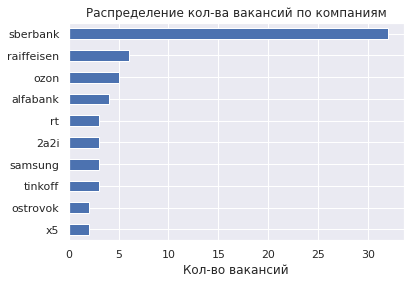

In [15]:
ax = df["company"].value_counts()[:10][::-1].plot.barh(title="Распределение кол-ва вакансий по компаниям")
ax.set_xlabel("Кол-во вакансий");

In [17]:
df["company"].value_counts()[:16].index

Index(['sberbank', 'raiffeisen', 'ozon', 'alfabank', 'rt', '2a2i', 'samsung',
       'tinkoff', 'ostrovok', 'x5', 'beeline', 'huawei', 'open', 'sportmaster',
       'sbdagroup', 'avito'],
      dtype='object')

Сначала построим ненаправленный граф, выделим у него наибольшую компоненту, а затем перейдем к направленному графу

Будем рассматривать только одну связную компоненту (это практически весь граф)

In [18]:
G = nx.Graph()
G.add_nodes_from(
    list(users.items()),
    company=[user["company"] for user in users.values],
    name=[user["name"] for user in users.values],
)

In [19]:
reactions = {
    "positive": [
        "+1",
        "+1::skin-tone-2",
        "+1::skin-tone-3",
        "+1::skin-tone-4",
        "+1::skin-tone-5",
        "+1::skin-tone-6",
        "100",
        "heart",
        "fire",
        "fireball",
        "notbad",
        "rocket",
        "chart_with_upwards_trend",
        "stonks",
        "moneys",
        "heavy_plus_sign",
    ],
    "negative": [
        "-1",
        "-1::skin-tone-2",
        "-1::skin-tone-4",
        "-1::skin-tone-5",
        "-1::skin-tone-6",
        "ban",
        "titanic",
        "thisisfine",
        "el_resitas_shake",
        "ramen",
        "hankey",
        "chart_with_downwards_trend",
        "heavy_minus_sign",
        "loh",
    ],
}

In [20]:
def fill_graph(G):
    for i, row in tqdm(df.iterrows()):
        if row["reactions"] is not np.nan:
            # all relevant users with reaction to this vacancy
            u_users = set(list(itertools.chain(*[r["users"] for r in row["reactions"]]))) & set(users.keys())
            u_reacts = defaultdict(list)
            for react in row["reactions"]:
                add = (
                    1
                    if react["name"] in reactions["positive"]
                    else 0
                    if react["name"] in reactions["negative"]
                    else 0.5
                )
                for u_user in react["users"]:
                    if u_user in u_users:
                        u_reacts[u_user].append(add)

            for u_user in u_reacts.keys():
                r = np.mean(u_reacts[u_user])
                G.add_edge(u_user, row["user"], reaction=r)

In [21]:
fill_graph(G)
G.remove_nodes_from(list(nx.isolates(G)))
G.remove_edges_from(nx.selfloop_edges(G))

0it [00:00, ?it/s]

In [22]:
len(G)

383

In [23]:
gcc = max(nx.connected_components(G), key=len)
gcc = G.subgraph(gcc).copy()
len(gcc)

374

In [24]:
nx.write_gexf(gcc, "undirected_graph.gexf")

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(
    list(users.items()),
    company=[user["company"] for user in users.values],
    name=[user["name"] for user in users.values],
)

fill_graph(G)
G.remove_nodes_from(list(nx.isolates(G)))
G.remove_edges_from(nx.selfloop_edges(G))

G = G.subgraph(gcc).copy()
len(G)

0it [00:00, ?it/s]

374

In [24]:
nx.write_gexf(G, "directed_graph.gexf")